<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/3_Model_data2years_FeaturesSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/new_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/HHP_release3/new_data


#Import Library

In [2]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [3]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [4]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [5]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [6]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [7]:
data = pd.read_csv('data2years.csv')

In [8]:
data = data[['MemberID',
 'AgeAtFirstClaim',
 'Unknown',
 'no_Claims',
 'no_Providers',
 'no_Specialties',
 'no_PCG',
 'no_Procedure',
 'sum_PayDelay',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Place_Inpatient Hospital',
 'Place_Office',
 'Place_Urgent Care',
 'DSFS_10-11 months',
 'DSFS_6- 7 months',
 'DSFS_7- 8 months',
 'DSFS_8- 9 months',
 'Charlson_1-2',
 'Procedure_EM',
 'Procedure_MED',
 'Procedure_RAD',
 'DrugSum',
 'LabSum',
 'TARGET']]

In [9]:
y = data['TARGET']
X = data.drop(['TARGET'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

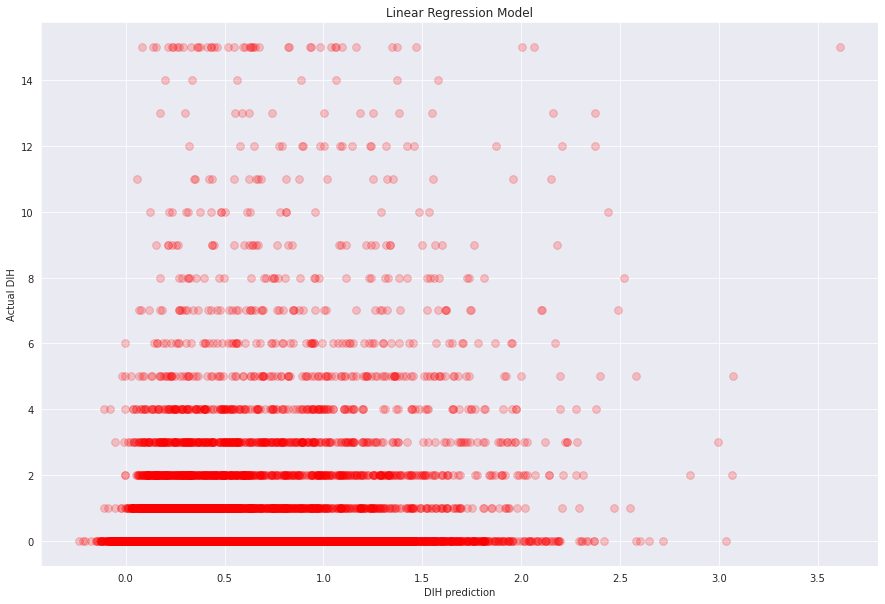

In [11]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_test)

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_test, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [12]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
eval(model_2, X_train, y_train, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.5231
R2 value of Stochastic Gradient Descent : 0.0244
Err value of Stochastic Gradient Descent : 0.5231


In [13]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_train, y_train, 'Lasso regression')

RMSLE of Lasso regression : 0.5138
R2 value of Lasso regression : 0.0300
Err value of Lasso regression : 0.5138


##MODEL 3: Neural Network

In [14]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [15]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)

Iteration 1, loss = 1.31647611
Iteration 2, loss = 1.15145724
Iteration 3, loss = 1.13403527
Iteration 4, loss = 1.12457287
Iteration 5, loss = 1.11894440
Iteration 6, loss = 1.11580796
Iteration 7, loss = 1.11319407
Iteration 8, loss = 1.11179371
Iteration 9, loss = 1.11016566
Iteration 10, loss = 1.10936475
Iteration 11, loss = 1.10851637
Iteration 12, loss = 1.10767344
Iteration 13, loss = 1.10735170
Iteration 14, loss = 1.10689446
Iteration 15, loss = 1.10638133
Iteration 16, loss = 1.10568401
Iteration 17, loss = 1.10529072
Iteration 18, loss = 1.10503475
Iteration 19, loss = 1.10478706
Iteration 20, loss = 1.10468729
Iteration 21, loss = 1.10405251
Iteration 22, loss = 1.10392363
Iteration 23, loss = 1.10363357
Iteration 24, loss = 1.10346408
Iteration 25, loss = 1.10348881
Iteration 26, loss = 1.10315998
Iteration 27, loss = 1.10265986
Iteration 28, loss = 1.10239050
Iteration 29, loss = 1.10182799
Iteration 30, loss = 1.10185897
Iteration 31, loss = 1.10181482
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=7, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

**Hyperparameter Optimization using Grid Search**

In [16]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))

In [17]:
#test_mse = mean_squared_error(y_test, rgr.predict(X_test))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

In [18]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=2, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)

Iteration 1, loss = 1.23804757
Iteration 2, loss = 1.18058195
Iteration 3, loss = 1.16537304
Iteration 4, loss = 1.15197697
Iteration 5, loss = 1.14465684
Iteration 6, loss = 1.13966641
Iteration 7, loss = 1.13613135
Iteration 8, loss = 1.13315100
Iteration 9, loss = 1.13108087
Iteration 10, loss = 1.12879594
Iteration 11, loss = 1.12694158
Iteration 12, loss = 1.12536735
Iteration 13, loss = 1.12371609
Iteration 14, loss = 1.12250031
Iteration 15, loss = 1.12118346
Iteration 16, loss = 1.12004734
Iteration 17, loss = 1.11892593
Iteration 18, loss = 1.11773170
Iteration 19, loss = 1.11716626
Iteration 20, loss = 1.11629176
Iteration 21, loss = 1.11553298
Iteration 22, loss = 1.11470554
Iteration 23, loss = 1.11435522
Iteration 24, loss = 1.11379316
Iteration 25, loss = 1.11333749
Iteration 26, loss = 1.11294138
Iteration 27, loss = 1.11266862
Iteration 28, loss = 1.11190575
Iteration 29, loss = 1.11159847
Iteration 30, loss = 1.11144181
Iteration 31, loss = 1.11113376
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=2, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='sgd',
             tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [19]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[02:19:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.50343	train-rmse:1.53367	test-RMSLE:0.518161	train-RMSLE:0.520269
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.49847	train-rmse:1.52862	test-RMSLE:0.513821	train-RMSLE:0.515791
[2]	test-rmse:1.4948	train-rmse:1.52488	test-RMSLE:0.510532	train-RMSLE:0.512387
[3]	test-rmse:1.49206	train-rmse:1.52207	test-RMSLE:0.507981	train-RMSLE:0.509739
[4]	test-rmse:1.48998	train-rmse:1.51993	test-RMSLE:0.505957	train-RMSLE:0.507637
[5]	test-rmse:1.48839	train-rmse:1.51829	test-RMSLE:0.504318	train-RMSLE:0.505934
[6]	test-rmse:1.48716	train-rmse:1.51702	test-RMSLE:0.502967	train-RMSLE:0.504531
[7]	test-rmse:1.4862	train-rmse:1.51602	test-RMSLE:0.501836	train-RMSLE:0.503358
[8]	test-rmse:1.48544	train-rmse:1.51524	test-RMSLE:0.500876	train-RMSLE:

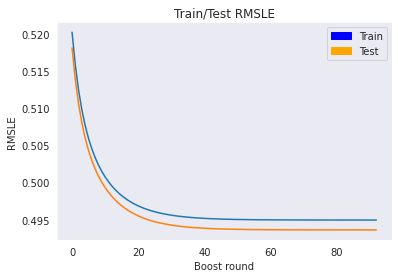

RMSLE Train set: 0.494963


In [21]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [22]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_default')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
eval(reg, X_test, y_test,'Gradient Boosting Regressor')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 

RMSLE of linear regression : 0.5156
R2 value of linear regression : 0.0245
Err value of linear regression : 0.5156
******
RMSLE of Stochastic Gradient Descent : 0.5243
R2 value of Stochastic Gradient Descent : 0.0189
Err value of Stochastic Gradient Descent : 0.5243
******
RMSLE of Lasso regression : 0.5154
R2 value of Lasso regression : 0.0256
Err value of Lasso regression : 0.5154
******
RMSLE of Neural Network_default : 0.5649
R2 value of Neural Network_default : -0.0418
Err value of Neural Network_default : 0.5649
******
RMSLE of Neural Network_random : 0.5108
R2 value of Neural Network_random : 0.0275
Err value of Neural Network_random : 0.5108
******
RMSLE of Neural Network_gridsearch : 0.5099
R2 value of Neural Network_gridsearch : 0.0279
Err value of Neural Network_gridsearch : 0.5099
******
RMSLE of Gradient Boosting Regressor : 0.5091
R2 value of Gradient Boosting Regressor : 0.0361
Err value of Gradient Boosting Regressor : 0.5091
******
Gradient Boost Linear Regression _ RM